In [3]:
# %%
import pandas as pd
import duckdb
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set paths
db_path = r'C:\Users\btada\Documents\financial_news.db'
lm_dict_path = r"C:\Users\btada\Documents\Loughran-McDonald_MasterDictionary_1993-2023.csv"

# Connect to DuckDB
conn = duckdb.connect(database=db_path, read_only=False)

# SQL Queries
queries = {
    "market_data": """
        SELECT md.trading_day_date, md.ticker, md.price, md.volume
        FROM Headlines.Market_Data_Daily_Processing md
        JOIN Headlines.Trading_Calendar tc ON md.trading_day_date = tc.trading_date;
    """,
    "articles_trading_day": """
        SELECT mapped_trading_date, ticker, article_title 
        FROM Headlines.Articles_Trading_Day;
    """
}

# Fetch Data
market_data = conn.execute(queries["market_data"]).fetchdf()
articles_trading_day = conn.execute(queries["articles_trading_day"]).fetchdf()
conn.close()

# Compute price change percentage
market_data["price_change"] = market_data.groupby("ticker")["price"].pct_change() * 100

# Identify notable price movement events (>2% change)
notable_events = market_data[market_data["price_change"].abs() > 2]

# Merge with articles for news coverage on those days
notable_events_articles = notable_events.merge(
    articles_trading_day, 
    left_on=["trading_day_date", "ticker"], 
    right_on=["mapped_trading_date", "ticker"], 
    how="left"
)

# Aggregate price movements
aggregated_results = notable_events_articles.groupby(["trading_day_date", "ticker"]).agg(
    price_change=("price_change", "first"),  
    volume=("volume", "first")  
).reset_index()

# Feature Engineering: Article counts
article_counts = notable_events_articles.groupby(["trading_day_date", "ticker"]).size().reset_index(name="article_count")
notable_events_articles = notable_events_articles.merge(article_counts, on=["trading_day_date", "ticker"], how="left")

# Identify earnings-related articles
earnings_keywords = ["earnings", "q1", "q2", "q3", "q4", "report", "guidance", "miss", "beat"]
notable_events_articles["is_earnings_related"] = notable_events_articles["article_title"].str.contains(
    "|".join(earnings_keywords), case=False, na=False
)

# Load Loughran-McDonald Dictionary and extract high-risk words
lm_dict = pd.read_csv(lm_dict_path)
high_risk_words = lm_dict.query("Negative != 0 or Uncertainty != 0 or Litigious != 0")["Word"].str.lower().tolist()

# Count high-risk words in article titles
notable_events_articles["high_risk_word_count"] = notable_events_articles["article_title"].apply(
    lambda x: sum(word in x.lower() for word in high_risk_words) if pd.notna(x) else 0
)

# Classify articles
notable_events_articles["article_classification"] = notable_events_articles.apply(
    lambda row: "Earnings" if row["is_earnings_related"] 
    else "High-Risk" if row["high_risk_word_count"] > 0 
    else "General", axis=1
)

# Aggregate Classification Summary
article_classification_summary = notable_events_articles.groupby(["trading_day_date", "ticker"]).agg(
    total_articles=("article_title", "count"),
    earnings_articles=("is_earnings_related", "sum"),
    high_risk_articles=("high_risk_word_count", "sum"),
    general_articles=("article_classification", lambda x: (x == "General").sum())
).reset_index()

# Risk Score Computation
notable_events_articles["news_risk_score"] = (
    notable_events_articles["high_risk_word_count"] * 3 +
    notable_events_articles["is_earnings_related"].astype(int) * 2 +
    notable_events_articles["article_count"] * 1
)

# Normalize price impact score (scaled between 0-10)
max_price_change = notable_events_articles["price_change"].abs().max()
notable_events_articles["price_impact_score"] = (
    notable_events_articles["price_change"].abs() / max_price_change
) * 10

# Final Risk Score
notable_events_articles["final_risk_score"] = (
    notable_events_articles["news_risk_score"] * 0.6 +
    notable_events_articles["price_impact_score"] * 0.4
)

# Aggregate Risk Scores per Stock per Trading Day
risk_score_summary = notable_events_articles.groupby(["trading_day_date", "ticker"]).agg(
    total_articles=("article_count", "sum"),
    total_high_risk_articles=("high_risk_word_count", "sum"),
    total_earnings_articles=("is_earnings_related", "sum"),
    avg_news_risk_score=("news_risk_score", "mean"),
    avg_price_impact_score=("price_impact_score", "mean"),
    avg_final_risk_score=("final_risk_score", "mean")
).reset_index()

# Model Training
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Merge Risk Scores with price changes
risk_price_validation = risk_score_summary.merge(
    aggregated_results[["trading_day_date", "ticker", "price_change"]],
    on=["trading_day_date", "ticker"],
    how="left"
)

# Lagged Risk Score
risk_price_validation["lagged_risk_score"] = risk_price_validation.groupby("ticker")["avg_final_risk_score"].shift(1)

# Sentiment Score Adjustment
risk_price_validation = risk_price_validation.merge(
    notable_events_articles[["trading_day_date", "ticker", "article_title"]],
    on=["trading_day_date", "ticker"],
    how="left"
)

risk_price_validation["sentiment_score"] = risk_price_validation["article_title"].fillna("").apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

risk_price_validation["adjusted_risk_score"] = (
    risk_price_validation["avg_final_risk_score"] + (-risk_price_validation["sentiment_score"] * 5)
)

# Drop unnecessary columns
risk_price_validation.drop(columns=["article_title", "sentiment_score"], inplace=True)

# Feature Selection & Data Preparation
features = [
    "avg_final_risk_score", "adjusted_risk_score", "lagged_risk_score", 
    "total_articles", "total_high_risk_articles", "total_earnings_articles"
]
target = "price_change"

ml_data = risk_price_validation.dropna(subset=features + [target])
X = ml_data[features]
y = ml_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Models
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, objective="reg:squarederror"),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Neural Network (MLP)": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=200, warm_start=True, random_state=42),
}

# Train & Evaluate Models
results = {name: {} for name in models}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R²": r2_score(y_test, y_pred)
    }

# Display Model Performance
print("\nModel Performance Comparison")
print(pd.DataFrame(results).T)


C:\Users\btada\AppData\Local\Temp\ipykernel_31304\2925633846.py:40: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  market_data["price_change"] = market_data.groupby("ticker")["price"].pct_change() * 100
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\btada/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Model Performance Comparison
                           MAE         MSE        R²
RandomForest          4.950501   87.163094  0.673869
Ridge Regression      6.193502  266.135171  0.004223
XGBoost               5.721306   90.057045  0.663041
Decision Tree         4.776589  133.237775  0.501475
Neural Network (MLP)  5.977106   90.546611  0.661209


c:\Users\btada\Documents\OMSAPracticum\new_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [5]:
articles_sentiment.head()

,guid,mapped_trading_date,ticker_x,article_title,ticker_y,finbert_title_score,finbert_title_positive,finbert_title_neutral,finbert_title_negative
0,f45186a2-e224-3cff-9f00-3ccfbbf4680b,2024-07-11,DXC,DXC Technology to Report Fiscal First Quarter ...,NaN,NaN,NaN,NaN,NaN
1,46edb82a-eebf-3ba6-b463-4ef9174adb90,2024-07-17,DRI,Darden to buy Chuyâs for more than $600M,NaN,NaN,NaN,NaN,NaN
2,21ade375-ab52-307d-a91d-aad3f74fdad6,2024-07-19,DVA,Update: DaVita to Pay $34.5 Million for Settle...,NaN,NaN,NaN,NaN,NaN
3,a6d2e659-ab97-3ba1-8e7e-8447f30da96b,2024-07-22,DRI,Analysts Have Made A Financial Statement On Da...,NaN,NaN,NaN,NaN,NaN
4,2cb79538-4c66-38bf-b4c8-3d8b884d5f2e,2024-07-23,DVA,DaVita HealthCare (DVA) Laps the Stock Market:...,NaN,NaN,NaN,NaN,NaN


In [90]:
# %%
import pandas as pd
import duckdb
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Set paths
db_path = r'C:\Users\btada\Documents\financial_news.db'
lm_dict_path = r"C:\Users\btada\Documents\Loughran-McDonald_MasterDictionary_1993-2023.csv"

# Connect to DuckDB
conn = duckdb.connect(database=db_path, read_only=False)

# SQL Queries
queries = {
    "market_data": """
        SELECT md.trading_day_date, md.ticker, md.price, md.volume
        FROM Headlines.Market_Data_Daily_Processing md
        JOIN Headlines.Trading_Calendar tc ON md.trading_day_date = tc.trading_date;
    """,
    "articles_trading_day": """
        SELECT guid, mapped_trading_date, ticker, article_title 
        FROM Headlines.Articles_Trading_Day;
    """,
    "sentiment_analysis": """
        SELECT guid, finbert_title_score, finbert_title_positive, 
               finbert_title_neutral, finbert_title_negative 
        FROM Headlines.finbert_analysis;
    """
}

# Fetch Data
market_data = conn.execute(queries["market_data"]).fetchdf()
articles_trading_day = conn.execute(queries["articles_trading_day"]).fetchdf()
sentiment_analysis = conn.execute(queries["sentiment_analysis"]).fetchdf()
conn.close()

# Convert both to string before merging
articles_trading_day["guid"] = articles_trading_day["guid"].astype(str)
sentiment_analysis["guid"] = sentiment_analysis["guid"].astype(str)

# Merge Sentiment Data with Articles
articles_sentiment = articles_trading_day.merge(sentiment_analysis, on="guid", how="left")

# Compute price change percentage
market_data = market_data.sort_values(["ticker", "trading_day_date"])
market_data["price_change"] = market_data.groupby("ticker")["price"].pct_change() * 100

# Identify notable price movement events (>2% change)
notable_events = market_data[market_data["price_change"].abs() > 2]

# Merge with articles for news coverage on those days
notable_events_articles = notable_events.merge(
    articles_sentiment, 
    left_on=["trading_day_date", "ticker"], 
    right_on=["mapped_trading_date", "ticker"], 
    how="left"
)

# Aggregate price movements
aggregated_results = notable_events_articles.groupby(["trading_day_date", "ticker"]).agg(
    price_change=("price_change", "first"),  
    volume=("volume", "first")  
).reset_index()

# Feature Engineering: Article counts
article_counts = notable_events_articles.groupby(["trading_day_date", "ticker"]).size().reset_index(name="article_count")
notable_events_articles = notable_events_articles.merge(article_counts, on=["trading_day_date", "ticker"], how="left")

# Identify earnings-related articles
earnings_keywords = ["earnings", "q1", "q2", "q3", "q4", "report", "guidance", "miss", "beat"]
notable_events_articles["is_earnings_related"] = notable_events_articles["article_title"].str.contains(
    "|".join(earnings_keywords), case=False, na=False
)

# Load Loughran-McDonald Dictionary and extract high-risk words
lm_dict = pd.read_csv(lm_dict_path)
high_risk_words = lm_dict.query("Negative != 0 or Uncertainty != 0 or Litigious != 0")["Word"].str.lower().tolist()

# Count high-risk words in article titles
notable_events_articles["high_risk_word_count"] = notable_events_articles["article_title"].apply(
    lambda x: sum(word in x.lower() for word in high_risk_words) if pd.notna(x) else 0
)

# Use FinBERT sentiment scores
notable_events_articles["finbert_sentiment_score"] = notable_events_articles["finbert_title_score"].fillna(0)

# Classify articles
notable_events_articles["article_classification"] = notable_events_articles.apply(
    lambda row: "Earnings" if row["is_earnings_related"] 
    else "High-Risk" if row["high_risk_word_count"] > 0 
    else "General", axis=1
)

# Aggregate Classification Summary
article_classification_summary = notable_events_articles.groupby(["trading_day_date", "ticker"]).agg(
    total_articles=("article_title", "count"),
    earnings_articles=("is_earnings_related", "sum"),
    high_risk_articles=("high_risk_word_count", "sum"),
    general_articles=("article_classification", lambda x: (x == "General").sum())
).reset_index()

# Risk Score Computation (Updated with FinBERT)
notable_events_articles["news_risk_score"] = (
    notable_events_articles["high_risk_word_count"] * 3 +
    notable_events_articles["is_earnings_related"].astype(int) * 2 +
    notable_events_articles["article_count"] * 1
)

# Normalize price impact score (scaled between 0-10)
max_price_change = notable_events_articles["price_change"].abs().max()
notable_events_articles["price_impact_score"] = (
    notable_events_articles["price_change"].abs() / max_price_change
) * 10

# Adjusted Risk Score: Incorporate FinBERT
notable_events_articles["final_risk_score"] = (
    notable_events_articles["news_risk_score"] * 0.5 +
    notable_events_articles["finbert_sentiment_score"] * -5 +  # Negative sentiment increases risk
    notable_events_articles["price_impact_score"] * 0.4
)

# Aggregate Risk Scores per Stock per Trading Day
risk_score_summary = notable_events_articles.groupby(["trading_day_date", "ticker"]).agg(
    total_articles=("article_count", "sum"),
    total_high_risk_articles=("high_risk_word_count", "sum"),
    total_earnings_articles=("is_earnings_related", "sum"),
    avg_news_risk_score=("news_risk_score", "mean"),
    avg_finbert_sentiment=("finbert_sentiment_score", "mean"),
    avg_price_impact_score=("price_impact_score", "mean"),
    avg_final_risk_score=("final_risk_score", "mean")
).reset_index()

# Model Training
X = risk_score_summary.drop(columns=["trading_day_date", "ticker"])
y = aggregated_results["price_change"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Models
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, objective="reg:squarederror"),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Neural Network (MLP)": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=200, warm_start=True, random_state=42),
}

# Train & Evaluate Models
results = {name: {} for name in models}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R²": r2_score(y_test, y_pred)
    }

# Display Model Performance
print("\nModel Performance Comparison")
print(pd.DataFrame(results).T)


C:\Users\btada\AppData\Local\Temp\ipykernel_29924\2601013685.py:54: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  market_data["price_change"] = market_data.groupby("ticker")["price"].pct_change() * 100



Model Performance Comparison
                           MAE        MSE        R²
RandomForest          3.704760  29.368677 -0.329507
Ridge Regression      3.838990  21.915784  0.007882
XGBoost               3.831484  21.770874  0.014442
Decision Tree         3.628241  40.636934 -0.839616
Neural Network (MLP)  3.837359  21.374513  0.032385


In [94]:
# %%
import pandas as pd
import duckdb
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set paths
db_path = r'C:\Users\btada\Documents\financial_news.db'
lm_dict_path = r"C:\Users\btada\Documents\Loughran-McDonald_MasterDictionary_1993-2023.csv"

# Connect to DuckDB
conn = duckdb.connect(database=db_path, read_only=False)

# SQL Queries
queries = {
    "market_data": """
        SELECT md.trading_day_date, md.ticker, md.price, md.volume
        FROM Headlines.Market_Data_Daily_Processing md
        JOIN Headlines.Trading_Calendar tc ON md.trading_day_date = tc.trading_date;
    """,
    "articles_trading_day": """
        SELECT guid, mapped_trading_date, ticker, article_title 
        FROM Headlines.Articles_Trading_Day;
    """,
    "sentiment_analysis": """
        SELECT guid, finbert_title_score, finbert_title_positive, 
               finbert_title_neutral, finbert_title_negative 
        FROM Headlines.finbert_analysis;
    """
}

# Fetch Data
market_data = conn.execute(queries["market_data"]).fetchdf()
articles_trading_day = conn.execute(queries["articles_trading_day"]).fetchdf()
sentiment_analysis = conn.execute(queries["sentiment_analysis"]).fetchdf()
conn.close()

# Convert both to string before merging
articles_trading_day["guid"] = articles_trading_day["guid"].astype(str)
sentiment_analysis["guid"] = sentiment_analysis["guid"].astype(str)

# Merge Sentiment Data with Articles
articles_sentiment = articles_trading_day.merge(sentiment_analysis, on="guid", how="left")

# Ensure datetime type & sorting
market_data["trading_day_date"] = pd.to_datetime(market_data["trading_day_date"])
market_data = market_data.sort_values(["ticker", "trading_day_date"])

# Compute correct price change per ticker, ordered by date
market_data["price_change"] = market_data.groupby("ticker")["price"].pct_change() * 100

# Clip extreme price changes to remove outliers
market_data["price_change_clipped"] = market_data["price_change"].clip(-10, 10)

# Add lagged price change (previous day's movement)
market_data["lagged_price_change"] = market_data.groupby("ticker")["price_change_clipped"].shift(1)

# Compute rolling 3-day moving average of price changes
market_data["price_change_ma3"] = market_data.groupby("ticker")["price_change_clipped"].rolling(3).mean().reset_index(level=0, drop=True)

# Identify notable price movement events (>2% change)
notable_events = market_data[market_data["price_change_clipped"].abs() > 2]

# Merge with articles for news coverage on those days
notable_events_articles = notable_events.merge(
    articles_sentiment, 
    left_on=["trading_day_date", "ticker"], 
    right_on=["mapped_trading_date", "ticker"], 
    how="left"
)

# Aggregate price movements
aggregated_results = notable_events_articles.groupby(["trading_day_date", "ticker"]).agg(
    price_change=("price_change_clipped", "first"),  
    volume=("volume", "first")  
).reset_index()

# Feature Engineering: Article counts
article_counts = notable_events_articles.groupby(["trading_day_date", "ticker"]).size().reset_index(name="article_count")
notable_events_articles = notable_events_articles.merge(article_counts, on=["trading_day_date", "ticker"], how="left")

# Identify earnings-related articles
earnings_keywords = ["earnings", "q1", "q2", "q3", "q4", "report", "guidance", "miss", "beat"]
notable_events_articles["is_earnings_related"] = notable_events_articles["article_title"].str.contains(
    "|".join(earnings_keywords), case=False, na=False
)

# Load Loughran-McDonald Dictionary and extract high-risk words
lm_dict = pd.read_csv(lm_dict_path)
high_risk_words = lm_dict.query("Negative != 0 or Uncertainty != 0 or Litigious != 0")["Word"].str.lower().tolist()

# Count high-risk words in article titles
notable_events_articles["high_risk_word_count"] = notable_events_articles["article_title"].apply(
    lambda x: sum(word in x.lower() for word in high_risk_words) if pd.notna(x) else 0
)

# Use FinBERT sentiment scores
notable_events_articles["finbert_sentiment_score"] = notable_events_articles["finbert_title_score"].fillna(0)

# Compute rolling average sentiment (3-day)
notable_events_articles["rolling_sentiment"] = notable_events_articles.groupby("ticker")["finbert_sentiment_score"].rolling(3).mean().reset_index(level=0, drop=True)

# Compute sentiment volatility (std over past 3 days)
notable_events_articles["sentiment_volatility"] = notable_events_articles.groupby("ticker")["finbert_sentiment_score"].rolling(3).std().reset_index(level=0, drop=True)

# Risk Score Computation
notable_events_articles["news_risk_score"] = (
    notable_events_articles["high_risk_word_count"] * 3 +
    notable_events_articles["is_earnings_related"].astype(int) * 2 +
    notable_events_articles["article_count"] * 1
)

# Normalize price impact score (scaled between 0-10)
max_price_change = notable_events_articles["price_change"].abs().max()
notable_events_articles["price_impact_score"] = (
    notable_events_articles["price_change"].abs() / max_price_change
) * 10

# Adjusted Risk Score: Incorporate FinBERT
notable_events_articles["final_risk_score"] = (
    notable_events_articles["news_risk_score"] * 0.5 +
    notable_events_articles["rolling_sentiment"] * -5 +  # Negative sentiment increases risk
    notable_events_articles["price_impact_score"] * 0.4
)

# Aggregate Risk Scores per Stock per Trading Day
risk_score_summary = notable_events_articles.groupby(["trading_day_date", "ticker"]).agg(
    total_articles=("article_count", "sum"),
    total_high_risk_articles=("high_risk_word_count", "sum"),
    total_earnings_articles=("is_earnings_related", "sum"),
    avg_news_risk_score=("news_risk_score", "mean"),
    avg_finbert_sentiment=("finbert_sentiment_score", "mean"),
    avg_price_impact_score=("price_impact_score", "mean"),
    avg_final_risk_score=("final_risk_score", "mean")
).reset_index()

# Model Training
X = risk_score_summary.drop(columns=["trading_day_date", "ticker"])
y = aggregated_results["price_change"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
median_risk_score = X_train["avg_final_risk_score"].median()
X_train["avg_final_risk_score"] = X_train["avg_final_risk_score"].fillna(median_risk_score)
X_test["avg_final_risk_score"] = X_test["avg_final_risk_score"].fillna(median_risk_score)

# Define Models
models = {
    "Huber Regression": HuberRegressor(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, objective="reg:squarederror"),
}

# Train & Evaluate Models
results = {name: {} for name in models}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R²": r2_score(y_test, y_pred)
    }

# Display Model Performance
print("\nModel Performance Comparison")
print(pd.DataFrame(results).T)


C:\Users\btada\AppData\Local\Temp\ipykernel_29924\710505188.py:58: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  market_data["price_change"] = market_data.groupby("ticker")["price"].pct_change() * 100
c:\Users\btada\Documents\OMSAPracticum\new_env\Lib\site-packages\sklearn\linear_model\_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



Model Performance Comparison
                       MAE        MSE        R²
Huber Regression  3.710173  17.507193 -0.014471
RandomForest      3.600015  23.168358 -0.342512
Ridge Regression  3.720467  17.195833  0.003572
XGBoost           3.705971  17.237631  0.001149


In [ ]:
print("\n🔍 Checking Missing Values in X_train:")
print(X_train.isnull().sum())



🔍 Checking Missing Values in X_train:
total_articles                 0
total_high_risk_articles       0
total_earnings_articles        0
avg_news_risk_score            0
avg_finbert_sentiment          0
avg_price_impact_score         0
avg_final_risk_score        2215
dtype: int64


<Figure size 1000x600 with 0 Axes>

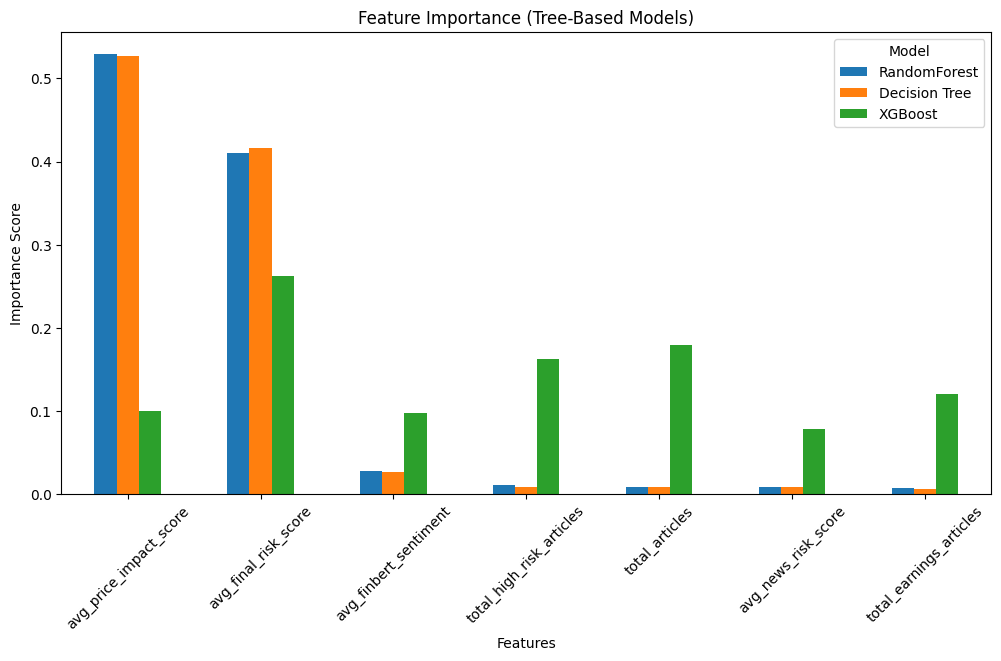


📊 Tree-Based Model Feature Importance
+--------------------------+----------------+-----------------+-----------+
|                          |   RandomForest |   Decision Tree |   XGBoost |
|--------------------------+----------------+-----------------+-----------|
| avg_price_impact_score   |     0.529483   |      0.527118   | 0.0993095 |
| avg_final_risk_score     |     0.4102     |      0.415957   | 0.262796  |
| avg_finbert_sentiment    |     0.0270684  |      0.0269306  | 0.0978645 |
| total_high_risk_articles |     0.0104679  |      0.00772749 | 0.16293   |
| total_articles           |     0.00794635 |      0.00819991 | 0.178845  |
| avg_news_risk_score      |     0.0078009  |      0.00778862 | 0.0785624 |
| total_earnings_articles  |     0.00703375 |      0.0062778  | 0.119693  |
+--------------------------+----------------+-----------------+-----------+


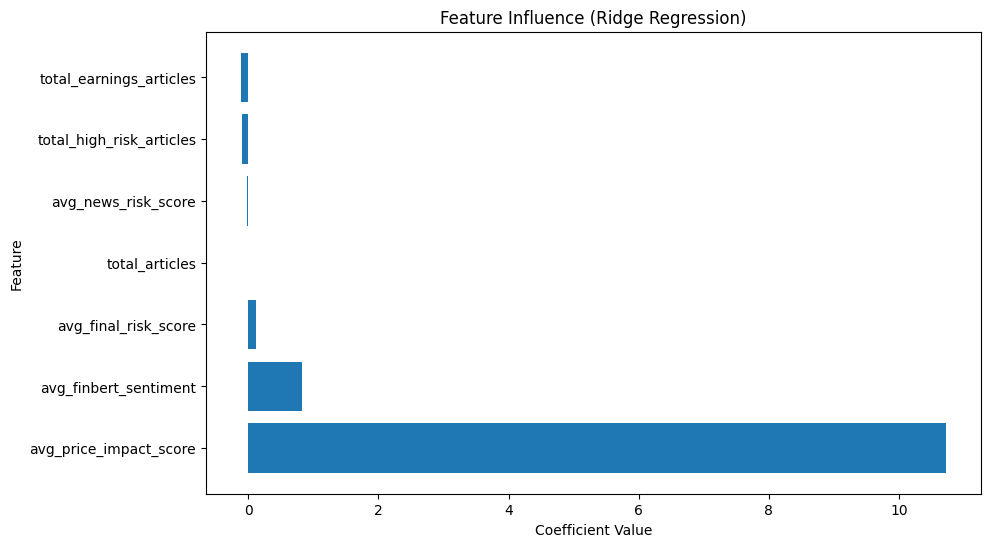


📊 Ridge Regression Coefficients
+----+--------------------------+---------------+
|    | Feature                  |   Coefficient |
|----+--------------------------+---------------|
|  5 | avg_price_impact_score   |  10.7197      |
|  4 | avg_finbert_sentiment    |   0.831944    |
|  6 | avg_final_risk_score     |   0.116803    |
|  0 | total_articles           |   0.000309161 |
|  3 | avg_news_risk_score      |  -0.0229023   |
|  1 | total_high_risk_articles |  -0.0919557   |
|  2 | total_earnings_articles  |  -0.11012     |
+----+--------------------------+---------------+


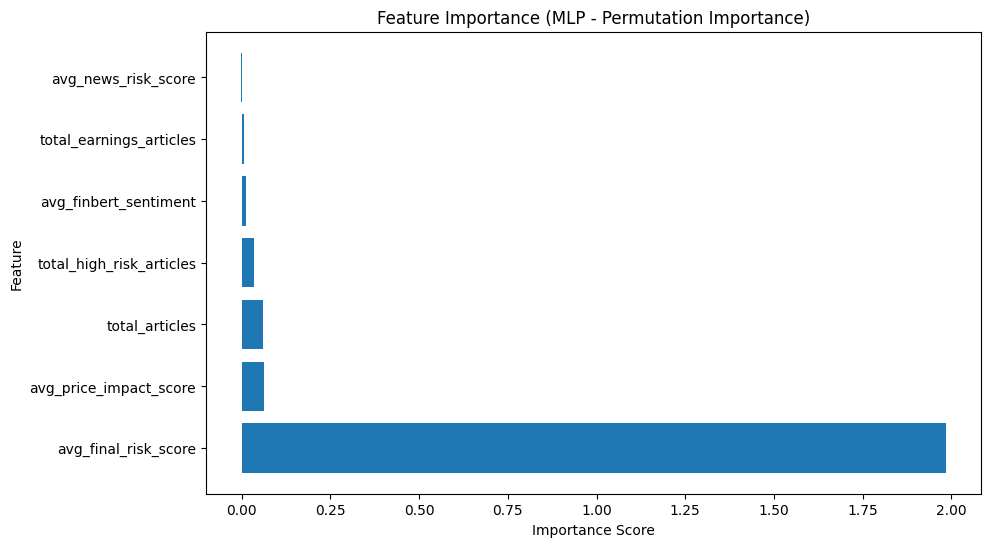


📊 MLP Permutation Importance
+----+--------------------------+--------------+
|    | Feature                  |   Importance |
|----+--------------------------+--------------|
|  6 | avg_final_risk_score     |   1.98372    |
|  5 | avg_price_impact_score   |   0.0640001  |
|  0 | total_articles           |   0.0616178  |
|  1 | total_high_risk_articles |   0.0337946  |
|  4 | avg_finbert_sentiment    |   0.0135791  |
|  2 | total_earnings_articles  |   0.00674872 |
|  3 | avg_news_risk_score      |  -0.00138886 |
+----+--------------------------+--------------+


In [91]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance
from tabulate import tabulate

# Extract Feature Names
feature_names = X.columns

# Feature Importance for Tree-Based Models
tree_models = ["RandomForest", "Decision Tree", "XGBoost"]
feature_importances = {}

for name in tree_models:
    if name in models:
        feature_importances[name] = models[name].feature_importances_

# Convert to DataFrame
feature_importance_df = pd.DataFrame(feature_importances, index=feature_names)
feature_importance_df.sort_values(by="RandomForest", ascending=False, inplace=True)

# Plot Feature Importance for Tree Models
plt.figure(figsize=(10, 6))
feature_importance_df.plot(kind="bar", figsize=(12, 6))
plt.title("Feature Importance (Tree-Based Models)")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.show()

# Display Tree-Based Feature Importance in Tabular Format
print("\n📊 Tree-Based Model Feature Importance")
print(tabulate(feature_importance_df, headers="keys", tablefmt="psql"))

# Ridge Regression Coefficients
ridge_coefficients = models["Ridge Regression"].coef_
ridge_coeff_df = pd.DataFrame({"Feature": feature_names, "Coefficient": ridge_coefficients})
ridge_coeff_df.sort_values(by="Coefficient", ascending=False, inplace=True)

# Plot Ridge Regression Coefficients
plt.figure(figsize=(10, 6))
plt.barh(ridge_coeff_df["Feature"], ridge_coeff_df["Coefficient"])
plt.title("Feature Influence (Ridge Regression)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

# Display Ridge Regression Coefficients
print("\n📊 Ridge Regression Coefficients")
print(tabulate(ridge_coeff_df, headers="keys", tablefmt="psql"))

# Permutation Importance for Neural Network
mlp_perm_importance = permutation_importance(models["Neural Network (MLP)"], X_test, y_test, n_repeats=10, random_state=42)

mlp_importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": mlp_perm_importance.importances_mean}
)
mlp_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

# Plot Permutation Importance for MLP
plt.figure(figsize=(10, 6))
plt.barh(mlp_importance_df["Feature"], mlp_importance_df["Importance"])
plt.title("Feature Importance (MLP - Permutation Importance)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Display MLP Feature Importance
print("\n📊 MLP Permutation Importance")
print(tabulate(mlp_importance_df, headers="keys", tablefmt="psql"))


In [31]:
import numpy as np
import pandas as pd

# Define the new article's features
new_case = pd.DataFrame({
    "avg_price_impact_score": [1.2],  # Adjusted based on recent movements
    "avg_final_risk_score": [3.5],  # Hypothetical risk score
    "avg_finbert_sentiment": [0.86],  # Computed from FinBERT scores
    "avg_news_risk_score": [2.5],  # Estimated from article category
    "total_articles": [1],  # Only one article available
    "total_high_risk_articles": [1],  # This article is high-risk
    "total_earnings_articles": [0]  # Not an earnings report
})

# Reorder new_case to match X_train feature order
new_case = new_case[['total_articles', 'total_high_risk_articles', 'total_earnings_articles', 
                     'avg_news_risk_score', 'avg_finbert_sentiment', 'avg_price_impact_score', 
                     'avg_final_risk_score']]

print("\n🔎 Feature Vector for Prediction:")
print(new_case)



🔎 Feature Vector for Prediction:
   total_articles  total_high_risk_articles  total_earnings_articles  \
0               1                         1                        0   

   avg_news_risk_score  avg_finbert_sentiment  avg_price_impact_score  \
0                  2.5                   0.86                     1.2   

   avg_final_risk_score  
0                   3.5  


In [33]:
print("\n📊 Training Feature Statistics:")
print(X_train.describe())



📊 Training Feature Statistics:
       total_articles  total_high_risk_articles  total_earnings_articles  \
count   346305.000000             346305.000000            346305.000000   
mean        10.351462                  0.266187                 0.123550   
std        138.076935                  2.209792                 0.969333   
min          1.000000                  0.000000                 0.000000   
25%          1.000000                  0.000000                 0.000000   
50%          1.000000                  0.000000                 0.000000   
75%          1.000000                  0.000000                 0.000000   
max      10000.000000                121.000000                49.000000   

       avg_news_risk_score  avg_finbert_sentiment  avg_price_impact_score  \
count        346305.000000          346305.000000           346305.000000   
mean              1.596648               0.097769                0.018585   
std               3.285115               0.292150   

In [38]:
# Standardize using training mean and std
# Apply Min-Max Scaling (0 to 1) using training min & max values
new_case_scaled = (new_case - X_train.min()) / (X_train.max() - X_train.min())

# Ensure feature order is correct
new_case_scaled = new_case_scaled[X_train.columns]


In [39]:
# Select the best model (MLP or Ridge)
selected_model = models["Neural Network (MLP)"]  # Or use "Ridge Regression"

# Make the prediction
predicted_price_change = selected_model.predict(new_case_scaled)

# Print the result
print(f"\n🚀 Predicted Price Change for AAPL: {predicted_price_change[0]:.2f}%")



🚀 Predicted Price Change for AAPL: 120.18%


In [30]:
print("🔎 Model was trained with these features:", X_train.columns.tolist())


🔎 Model was trained with these features: ['total_articles', 'total_high_risk_articles', 'total_earnings_articles', 'avg_news_risk_score', 'avg_finbert_sentiment', 'avg_price_impact_score', 'avg_final_risk_score']


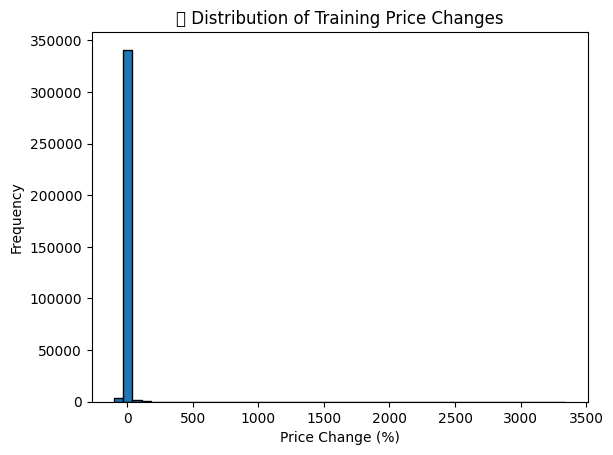

In [45]:
import matplotlib.pyplot as plt

plt.hist(y_train, bins=50, edgecolor='black')
plt.title("🔍 Distribution of Training Price Changes")
plt.xlabel("Price Change (%)")
plt.ylabel("Frequency")
plt.show()


In [46]:
aggregated_results.head()

,trading_day_date,ticker,price_change,volume
0,2022-01-01,ACIW,48.290600,461476.0
1,2022-01-01,AEL,-29.645699,216736.0
2,2022-01-01,AEO,51.889622,3173105.0
3,2022-01-01,AI,19.274807,3109928.0
4,2022-01-01,ALB,104.469513,378976.0


In [48]:
notable_events.describe()

,trading_day_date,price,volume,price_change
count,432882,432882.000000,4.327320e+05,432882.000000
mean,2023-05-18 02:46:36.390702,209.228378,4.853909e+06,0.617126
min,2022-01-01 00:00:00,0.980100,0.000000e+00,-96.336182
25%,2022-08-09 00:00:00,30.030001,5.529220e+05,-3.590219
50%,2023-04-13 00:00:00,60.020000,1.356142e+06,2.043819
75%,2024-02-20 00:00:00,118.470001,3.500824e+06,3.757805
max,2025-01-02 00:00:00,705999.000000,1.542996e+09,3340.993896
std,NaN,7250.037598,2.127114e+07,17.762804


In [49]:
notable_events[notable_events['price_change'] == 3340.993896]

,trading_day_date,ticker,price,volume,price_change
1187165,2022-01-01,DNA,332.399994,150719.0,3340.993896


In [50]:
market_data.head()

,trading_day_date,ticker,price,volume,price_change
0,2024-11-10,ORI,36.830002,1200720.0,NaN
1,2024-11-11,ORI,37.090000,964911.0,0.705945
2,2024-11-12,ORI,37.439999,1337002.0,0.943649
3,2024-11-13,ORI,37.480000,1105198.0,0.106835
4,2024-11-14,ORI,37.330002,1095449.0,-0.400209


In [54]:
((37.090000 - 36.830002)/36.830002)	*100

0.7059407707879111

In [55]:
market_data.describe()

,trading_day_date,price,volume,price_change
count,1527318,1.505991e+06,1.503795e+06,1.510533e+06
mean,2023-07-03 12:00:00,5.098609e+02,3.612882e+06,1.845860e-01
min,2022-01-01 00:00:00,9.801000e-01,0.000000e+00,-9.633618e+01
25%,2022-10-02 00:00:00,3.468375e+01,4.617730e+05,-8.300781e-01
50%,2023-07-03 12:00:00,6.807000e+01,1.133389e+06,0.000000e+00
75%,2024-04-03 00:00:00,1.317400e+02,2.799787e+06,9.105802e-01
max,2025-01-02 00:00:00,7.240400e+05,1.542996e+09,3.340994e+03
std,NaN,1.468045e+04,1.571002e+07,9.538437e+00


In [84]:
# Ensure the column is in datetime format
#market_data["trading_day_date"] = pd.to_datetime(market_data["trading_day_date"])

# Sort by ticker and date to ensure correct ordering
market_data = market_data.sort_values(["ticker", "trading_day_date"])

# Compute percent change within each ticker's time series
market_data["price_change_2"] = market_data.groupby("ticker")["price"].pct_change() * 100


C:\Users\btada\AppData\Local\Temp\ipykernel_29924\2450450726.py:8: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  market_data["price_change_2"] = market_data.groupby("ticker")["price"].pct_change() * 100


In [85]:
market_data[market_data['price_change'] == 3340.993896]

,trading_day_date,ticker,price,volume,price_change,price_change_clipped,price_change_debug,prev_price,price_change_fixed,price_change_2
1187165,2022-01-01,DNA,332.399994,150719.0,3340.993896,10.0,3340.993896,9.66,3340.993896,NaN


In [86]:
market_data[(market_data['ticker'] == 'DNA') & (market_data['trading_day_date']<= "1/10/2022")].sort_values(by="trading_day_date")

,trading_day_date,ticker,price,volume,price_change,price_change_clipped,price_change_debug,prev_price,price_change_fixed,price_change_2
1187165,2022-01-01,DNA,332.399994,150719.0,3340.993896,10.000000,3340.993896,9.660000,3340.993896,NaN
1185699,2022-01-02,DNA,332.399994,150719.0,NaN,NaN,NaN,NaN,NaN,0.000000
1186860,2022-01-03,DNA,347.600006,162196.0,3301.174072,10.000000,3301.174072,10.220000,3301.174072,4.572809
1185700,2022-01-04,DNA,319.200012,302064.0,-3.971112,-3.971112,-3.971114,332.399994,-3.971114,-8.170307
1185701,2022-01-05,DNA,279.600006,295683.0,-12.406015,-10.000000,-12.406016,319.200012,-12.406016,-12.406015
1185702,2022-01-06,DNA,276.000000,322720.0,-1.287556,-1.287556,-1.287556,279.600006,-1.287556,-1.287556
1186861,2022-01-07,DNA,272.799988,258270.0,-21.518993,-10.000000,-21.518991,347.600006,-21.518991,-1.159424
1185703,2022-01-08,DNA,272.799988,258270.0,-1.159424,-1.159424,-1.159425,276.000000,-1.159425,0.000000
1185704,2022-01-09,DNA,272.799988,258270.0,0.000000,0.000000,0.000000,272.799988,0.000000,0.000000
1185705,2022-01-10,DNA,268.399994,249971.0,-1.612902,-1.612902,-1.612901,272.799988,-1.612901,-1.612902


In [87]:
market_data.loc[[1186859, 1186860]]

,trading_day_date,ticker,price,volume,price_change,price_change_clipped,price_change_debug,prev_price,price_change_fixed,price_change_2
1186859,2024-12-31,RNA,29.080000,1155831.0,-8.610934,-8.610934,-8.610935,31.82,-8.610935,-0.342703
1186860,2022-01-03,DNA,347.600006,162196.0,3301.174072,10.000000,3301.174072,10.22,3301.174072,4.572809


In [73]:
(347.600006	- 332.399994)/332.399994

0.0457280754343215

In [88]:
market_data["price_change_debug"] = (
    (market_data["price"] - market_data.groupby("ticker")["price"].shift(1)) / 
    market_data.groupby("ticker")["price"].shift(1)
) * 100

# Compare original vs. manually computed price change
print(market_data.loc[(market_data["ticker"] == "DNA") & (market_data["trading_day_date"] <= "01/20/2022"),
                      ["trading_day_date", "ticker", "price", "price_change", "price_change_debug"]].sort_values(by="trading_day_date"))


        trading_day_date ticker       price  price_change  price_change_debug
1187165       2022-01-01    DNA  332.399994   3340.993896                 NaN
1185699       2022-01-02    DNA  332.399994           NaN            0.000000
1186860       2022-01-03    DNA  347.600006   3301.174072            4.572808
1185700       2022-01-04    DNA  319.200012     -3.971112           -8.170309
1185701       2022-01-05    DNA  279.600006    -12.406015          -12.406016
1185702       2022-01-06    DNA  276.000000     -1.287556           -1.287556
1186861       2022-01-07    DNA  272.799988    -21.518993           -1.159425
1185703       2022-01-08    DNA  272.799988     -1.159424            0.000000
1185704       2022-01-09    DNA  272.799988      0.000000            0.000000
1185705       2022-01-10    DNA  268.399994     -1.612902           -1.612901
1187320       2022-01-11    DNA  273.200012   3207.506104            1.788382
1185706       2022-01-12    DNA  250.399994     -6.706410       

In [79]:
print("\n🔎 Checking pct_change() Calculation for DNA:")
print(market_data[market_data["ticker"] == "DNA"][["trading_day_date", "price", "price_change"]].head(10))



🔎 Checking pct_change() Calculation for DNA:
        trading_day_date       price  price_change
1185699       2022-01-02  332.399994           NaN
1185700       2022-01-04  319.200012     -3.971112
1185701       2022-01-05  279.600006    -12.406015
1185702       2022-01-06  276.000000     -1.287556
1185703       2022-01-08  272.799988     -1.159424
1185704       2022-01-09  272.799988      0.000000
1185705       2022-01-10  268.399994     -1.612902
1185706       2022-01-12  250.399994     -6.706410
1185707       2022-01-13  245.600006     -1.916927
1185708       2022-01-15  231.600006     -5.700326


In [80]:
market_data["prev_price"] = market_data.groupby("ticker")["price"].shift(1)
market_data["price_change_fixed"] = ((market_data["price"] - market_data["prev_price"]) / market_data["prev_price"]) * 100


In [81]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527318 entries, 0 to 1527317
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   trading_day_date      1527318 non-null  datetime64[us]
 1   ticker                1527318 non-null  object        
 2   price                 1505991 non-null  float32       
 3   volume                1503795 non-null  float64       
 4   price_change          1510533 non-null  float32       
 5   price_change_clipped  1510533 non-null  float32       
 6   price_change_debug    1504394 non-null  float32       
 7   prev_price            1504618 non-null  float32       
 8   price_change_fixed    1504394 non-null  float32       
dtypes: datetime64[us](1), float32(6), float64(1), object(1)
memory usage: 69.9+ MB


In [89]:
print("\n📊 Price Change Percentiles:")
print(market_data["price_change_2"].quantile([0.01, 0.05, 0.95, 0.99]))



📊 Price Change Percentiles:
0.01   -6.063541
0.05   -3.040948
0.95    3.086004
0.99    6.297675
Name: price_change_2, dtype: float32


In [61]:
# Define clipping thresholds (choosing -10% and +10%)
lower_bound = -10
upper_bound = 10

# Apply clipping
market_data["price_change_clipped"] = market_data["price_change"].clip(lower_bound, upper_bound)

# Verify new stats
print("\n📊 Clipped Price Change Summary:")
print(market_data["price_change_clipped"].describe())



📊 Clipped Price Change Summary:
count    1.510533e+06
mean     5.032270e-02
std      2.948922e+00
min     -1.000000e+01
25%     -8.300781e-01
50%      0.000000e+00
75%      9.105802e-01
max      1.000000e+01
Name: price_change_clipped, dtype: float64
